<a href="https://colab.research.google.com/github/michalcohen/DataAnalysisABC/blob/main/proof_table_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import tqdm
from multiprocess import Pool
from pandas import DataFrame as df
from os.path import join
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
dirname = "../abc/beem"
frames_list = [filename for filename in os.listdir(dirname) if filename.endswith(".aig")]
max_pool = 12

        
def process_aig(f):
    os.system("cd ../abc && ./abc -c \"r " + os.path.join("beem", f) + "; dprove\"")
    return f

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm.tqdm(
            p.imap(process_aig,
                   frames_list),
            total=len(frames_list)
        )
    )

  0%|          | 1/687 [00:05<59:32,  5.21s/it]


KeyboardInterrupt: 

In [22]:
dirname = "../abc/beem"
file_list = [filename for filename in os.listdir(dirname) if filename.endswith(".csv")][0:1]
max_pool = 12

def process_file(file):
    x = pd.read_csv(join(dirname, file))
    x = x.drop(x[x.nRef < 0].index)
    return x
    
with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm.tqdm(
            p.imap(process_file,
                   file_list),
            total=len(file_list)
        )
    )
tot = pd.concat(pool_outputs)
tot

100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


,state,nRef
0,0x7ffff6685c30,8
1,0x7ffff6685b60,6
2,0x7ffff66857e0,11
3,0x7ffff6685420,33
4,0x7ffff6684fb0,17
...,...,...
499,0x7ffff322ce60,478
500,0x7ffff3221a20,2
501,0x7ffff30d9950,4
502,0x7ffff321ea00,1


<AxesSubplot:xlabel='nRef', ylabel='Count'>

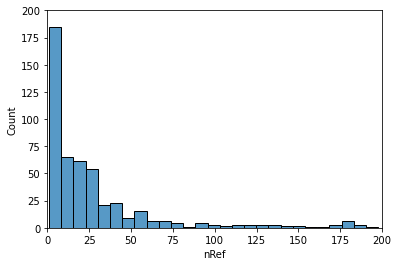

In [24]:
plt.ylim(0, 200)
plt.xlim(0, 200)
sns.histplot(data=tot, x="nRef")

In [39]:
dirname = "../abc/beem"
results_list = [filename for filename in os.listdir(dirname) if filename.endswith(".txt")]
max_pool = 12


def calc_max_save_per_iter(d: Dict[str, List[Tuple[str, int]]]) -> pd.DataFrame:
    max_iter = max(visits[-1][1] for visits in d.values())
    saves_per_iter = {i: (i, max((len([visit for visit in visits if visit[1] > i])) for visits in d.values())) for i in
                      range(max_iter)}
    return pd.DataFrame.from_dict(saves_per_iter, orient='index', columns=["iter", "max_save"])


def process_file(file) -> pd.DataFrame:
    d: Dict[str, List[Tuple[str, int]]] = dict()
    with open(join(dirname, file), 'r') as f:
        for line in f.readlines():
            vals: List[str] = line.split(",")
            d[vals[0]] = [(tup.split(":")[0], int(tup.split(":")[1])) for tup in vals[1:-1]]
            d[vals[0]] = list(set(d[vals[0]]))
            d[vals[0]].sort(key=lambda tup: tup[1])
        return calc_max_save_per_iter(d)


with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm.tqdm(
            p.imap(process_file,
                   results_list),
            total=len(results_list)
        )
    )
    total_result = pd.concat(pool_outputs, ignore_index=True)
    total_result.to_csv("../abc/total_results.csv")


100%|██████████| 522/522 [02:47<00:00,  3.12it/s]  


In [29]:
total_results = pd.read_csv("../abc/total_results.csv")
total_results

,Unnamed: 0,iter,max_save
0,0,0,12937
1,1,1,12936
2,2,2,12925
3,3,3,12925
4,4,4,12912
...,...,...,...
8663,8663,9,178
8664,8664,10,84
8665,8665,11,34
8666,8666,12,34


<AxesSubplot:xlabel='iter', ylabel='max_save'>

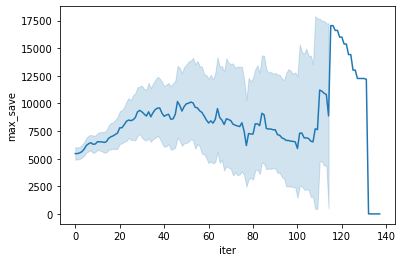

In [40]:
sns.lineplot(data=total_results, x="iter", y="max_save")